## Setup

In [245]:
import setup
setup.main()

%load_ext autoreload
%autoreload 2

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom/neuralwarp
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom/neuralwarp
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [242]:
import pyLDDMM
from pyLDDMM.utils.visualization import loadimg, saveimg, save_animation, plot_warpgrid
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import torch
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs

from geomstats.geometry.pullback_metric import PullbackMetric

# Examples: Circle to Square

## Load images

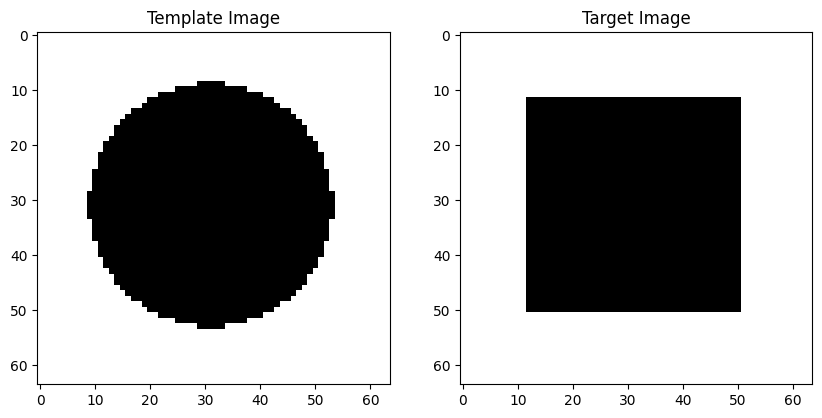

In [244]:
i0 = loadimg('./example_images/circle.png')
i1 = loadimg('./example_images/square.png')

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(i0, cmap='gray')
ax1.set_title('Template Image')
ax2 = fig.add_subplot(122)
ax2.imshow(i1, cmap='gray')
ax2.set_title('Target Image');

## Run LDDMM algorithm

### Algorithm Inputs:
$I_0$: image, ndarray of dimension $H \times W \times n$

$I_1$: image, ndarray of dimension $H \times W \times n$

$T$: int, simulated discrete time steps

$K$: int, maximum iterations

$\sigma$: float, sigma for $L_2$ loss. lower values strengthen the $L_2$ loss

$\alpha$: float, smoothness regularization. Higher values regularize stronger

$\gamma$: float, norm penalty. Positive value to ensure injectivity of the regularizer

$\epsilon$: float, learning rate

### Algorithm Outputs:

$\phi_0$: forward flow

$\phi_1$: backward flow

$J_0$: time-series images generated by forward-pushing $I_0$ using forward flow

$J_1$: time-series images generated by pulling-back $I_1$ using backward flow

$\text{length}$: length of path on the manifold

$v$: final velocity field

$\text{energies}$:

$\text{im}$: $\text{im} = J_0[-1]$

In [214]:
lddmm = pyLDDMM.LDDMM2D()
im, v, energies, length, Phi0, Phi1, J0, J1 = lddmm.register(i0, i1, sigma=0.05, alpha=1, epsilon=0.0001, K=200)

iteration   0, energy 110400.00, thereof 0.00 regularization and 110400.00 intensity difference
iteration   1, energy 31376.69, thereof 56.71 regularization and 31319.99 intensity difference
iteration   2, energy 12797.85, thereof 68.09 regularization and 12729.77 intensity difference
iteration   3, energy 8087.11, thereof 73.68 regularization and 8013.43 intensity difference
iteration   4, energy 5748.45, thereof 77.48 regularization and 5670.97 intensity difference
iteration   5, energy 4167.99, thereof 79.65 regularization and 4088.34 intensity difference
iteration   6, energy 3341.06, thereof 81.71 regularization and 3259.35 intensity difference
iteration   7, energy 3302.86, thereof 82.79 regularization and 3220.07 intensity difference
iteration   8, energy 3206.30, thereof 84.61 regularization and 3121.69 intensity difference
iteration   9, energy 3263.73, thereof 85.24 regularization and 3178.50 intensity difference
iteration  10, energy 3093.66, thereof 86.96 regularization and

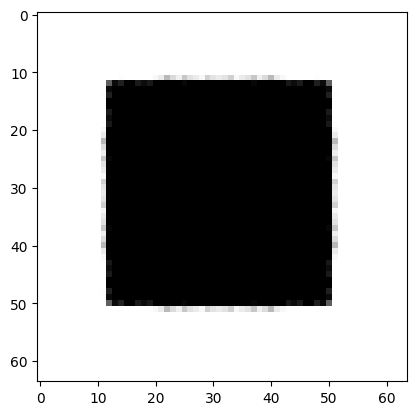

In [215]:
plt.imshow(im, cmap='gray')

## Visualize velocity vector field over time

INFO: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


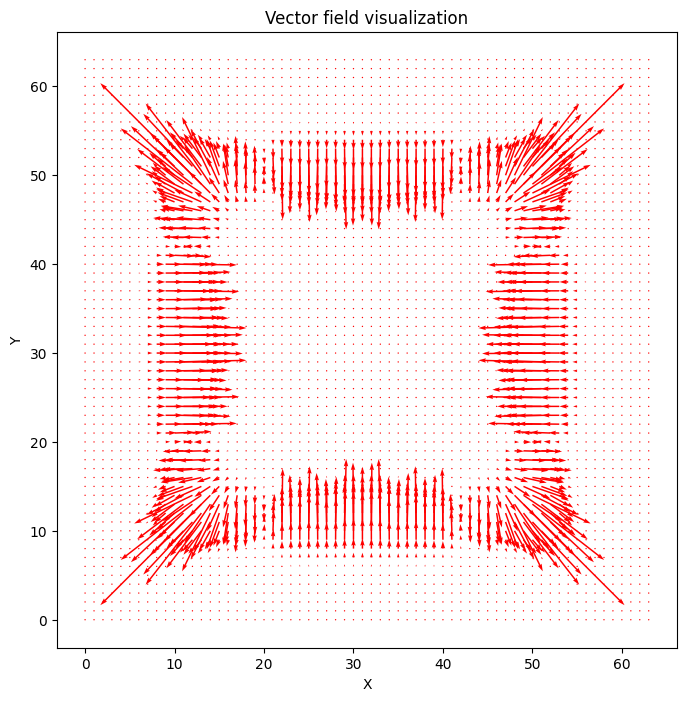

In [216]:
time_points = v.shape[0]
num_rows = v.shape[1]
num_columns = v.shape[2]

# Create a grid of points
x = np.linspace(0, num_columns - 1, num_columns)
y = np.linspace(0, num_rows - 1, num_rows)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(8, 8))

# Create a quiver plot for the initial vector field
Q = ax.quiver(X, Y, v[0, :, :, 0], v[0, :, :, 1], color='red')

ax.set_title('Vector field visualization')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Update function for the animation
def update(num):
    U = v[num, :, :, 0]
    V = v[num, :, :, 1]
    
    # Update the data for the quiver plot
    Q.set_UVC(U, V)
    
    return Q,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(time_points), blit=True)

HTML(ani.to_jshtml())


## 

## Visualize grid distortion

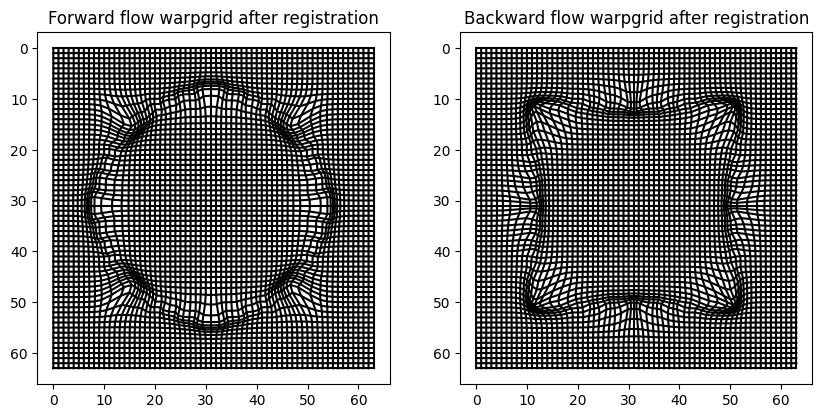

In [217]:
fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot(121)
ax0 = plot_warpgrid(Phi0[-1], interval=1, show_axis=True)
ax0.set_title('Forward flow warpgrid after registration');

ax1 = fig.add_subplot(122)
ax1 = plot_warpgrid(Phi1[0], interval=1, show_axis=True)
ax1.set_title('Backward flow warpgrid after registration');

# Examples: Distorted Gaussians

In [236]:
from scipy.stats import multivariate_normal


def create_gaussian_image(width, height, resolution, x_variance, y_variance, distance):
    x = np.linspace(0, width-1, int(width/resolution))
    y = np.linspace(0, height-1, int(height/resolution))
    x, y = np.meshgrid(x, y)
    

    pos = np.dstack((x, y))

    mu1 = np.array([width/2-distance/2, height/2]) 
    cov1 = np.array([[x_variance, 0], [0, y_variance]])  # covariance matrix

    rv1 = multivariate_normal(mu1, cov1)
    
    mu2 = np.array([width/2+distance/2, height/2]) 
    cov2 = np.array([[x_variance, 0], [0, y_variance]])  # covariance matrix

    rv2 = multivariate_normal(mu2, cov2)
    
    
    
    intensity_values1 = rv1.pdf(pos)
    intensity_values2 = rv2.pdf(pos)
    intensity_values = intensity_values1 + intensity_values2
    intensity_values = intensity_values/np.sum(intensity_values)

    return intensity_values

def create_uniform_image(width, height, resolution):
    x = np.linspace(-1, 1, int(width/resolution))
    y = np.linspace(-1, 1, int(height/resolution))
    x, y = np.meshgrid(x, y)


    # Calculate intensity values based on distance from center
    intensity_values = np.ones_like(x)
    
    intensity_values = intensity_values/np.sum(intensity_values)

    return intensity_values

In [263]:
image1 = create_gaussian_image(width=10,height=10,resolution=0.2,x_variance=0.2,y_variance=0.4, distance=4)

image2 = create_gaussian_image(width=10,height=10,resolution=0.2,x_variance=1,y_variance=0.4, distance=4)
#image2 = create_uniform_image(width=5,height=5,resolution=0.1)

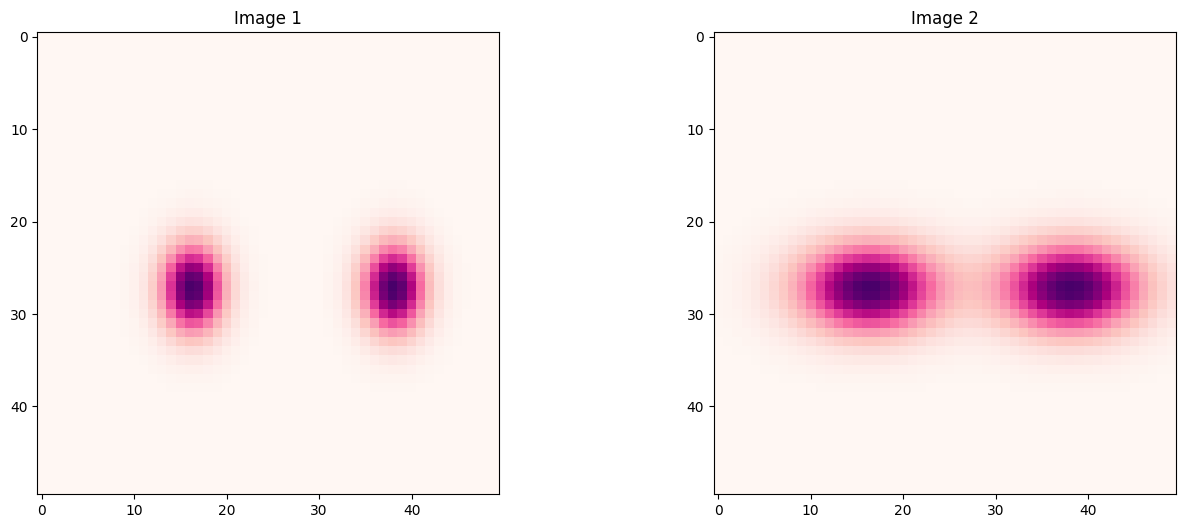

In [264]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first image on the first subplot
axs[0].imshow(image1, cmap='RdPu')
axs[0].set_title('Image 1')

# Plot the second image on the second subplot
axs[1].imshow(image2, cmap='RdPu')
axs[1].set_title('Image 2')

# Display the plots
plt.show()

# Learn deformation with FNN

In [218]:
# hyperparameters
train_ratio = 0.8
batch_size = 10
learning_rate = 0.001

# hardware
device = "cuda" if torch.cuda.is_available() else "mps"

### Load data

In [219]:
x_in = Phi0[0]
x_out = Phi0[-1]

# reshape
input_data = x_in.reshape((-1, 2))
output_data = x_out.reshape((-1, 2))

# shuffle data
idx = np.arange(input_data.shape[0])
np.random.shuffle(idx)
input_data = input_data[idx]
output_data = output_data[idx]

input_data = torch.from_numpy(input_data).float()
output_data = torch.from_numpy(output_data).float()

n_train = int(input_data.shape[0] * train_ratio)

train_dataset = torch.utils.data.TensorDataset(input_data[:n_train], output_data[:n_train])
val_dataset = torch.utils.data.TensorDataset(input_data[n_train:], output_data[n_train:])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [234]:
class FCNET(torch.nn.Module):
    def __init__(self, input_dim, output_dim, n_layers, n_neurons, activation):
        super(FCNET, self).__init__()
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.layers = torch.nn.ModuleList()
        self.activation = activation
        for i in range(n_layers):
            self.layers.append(torch.nn.Linear(input_dim if i == 0 else n_neurons, n_neurons))     
        self.out = torch.nn.Linear(n_neurons, output_dim)
        self.layers.append(self.out)

    def forward(self, x): 
        x_in = x                        
        for i in range(self.n_layers):
            x = self.layers[i](x)
            x = self.activation(x)
        x = self.out(x)
        return x + x_in

In [235]:
# train the neural network on the training dataset and validate on the validation dataset
def train_and_validate(net, train_dataloader, val_dataloader, optimizer, criterion,n_epochs, checkpoint_num):
    train_loss = []
    val_loss = []
    for epoch in range(n_epochs):
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = net(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        if epoch % checkpoint_num == 0:
            print('Epoch %d, train loss %.4f' % (epoch, loss.item()))
        with torch.no_grad():
            for x, y in val_dataloader:
                x = x.to(device)
                y = y.to(device)
                y_pred = net(x)
                loss = criterion(y_pred, y)
            val_loss.append(loss.item())
            if epoch % checkpoint_num == 0:
                print('Epoch %d, val loss %.4f' % (epoch, loss.item()))
    return train_loss, val_loss


In [236]:
# Define the model
net = FCNET(input_dim=2, output_dim=2, n_layers=3, n_neurons=100, activation=torch.nn.Tanh())
net = net.float()
net.to(device)

# Define the optimizer and the loss function
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, amsgrad=True)
criterion = torch.nn.MSELoss()

In [237]:
n_epochs = 40
checkpoint_num = 2
train_loss, test_loss = train_and_validate(net, train_dataloader, val_dataloader, optimizer, criterion, n_epochs, checkpoint_num)

Epoch 0, train loss 0.4989
Epoch 0, val loss 0.1399
Epoch 2, train loss 0.0238
Epoch 2, val loss 0.1495
Epoch 4, train loss 0.5433
Epoch 4, val loss 0.4028
Epoch 6, train loss 0.1816
Epoch 6, val loss 0.0638
Epoch 8, train loss 0.2393
Epoch 8, val loss 0.1293
Epoch 10, train loss 0.1127
Epoch 10, val loss 0.3855
Epoch 12, train loss 1.4760
Epoch 12, val loss 0.3169
Epoch 14, train loss 0.3895
Epoch 14, val loss 0.1755
Epoch 16, train loss 0.0274
Epoch 16, val loss 0.4109
Epoch 18, train loss 0.1041
Epoch 18, val loss 0.1649
Epoch 20, train loss 1.4436
Epoch 20, val loss 0.1519
Epoch 22, train loss 0.3341
Epoch 22, val loss 0.6778
Epoch 24, train loss 0.0805
Epoch 24, val loss 0.2927
Epoch 26, train loss 0.0967
Epoch 26, val loss 0.0872
Epoch 28, train loss 0.1244
Epoch 28, val loss 0.1275
Epoch 30, train loss 0.0732
Epoch 30, val loss 0.4283
Epoch 32, train loss 0.0182
Epoch 32, val loss 0.2706
Epoch 34, train loss 0.0258
Epoch 34, val loss 0.0634
Epoch 36, train loss 0.0499
Epoch 36, 

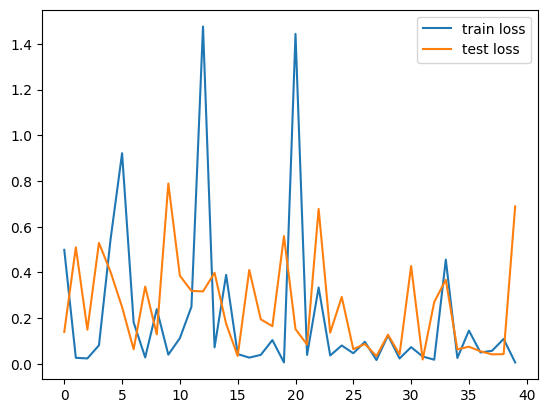

In [238]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

In [239]:
x_in_reshape = x_in.reshape((-1, 2))
x_in_reshape = torch.from_numpy(x_in_reshape).float()
x_in_reshape = x_in_reshape.to(device)
x_out_pred = net(x_in_reshape)
x_out_pred = x_out_pred.cpu().detach().numpy()
x_out_pred = x_out_pred.reshape(x_in.shape)

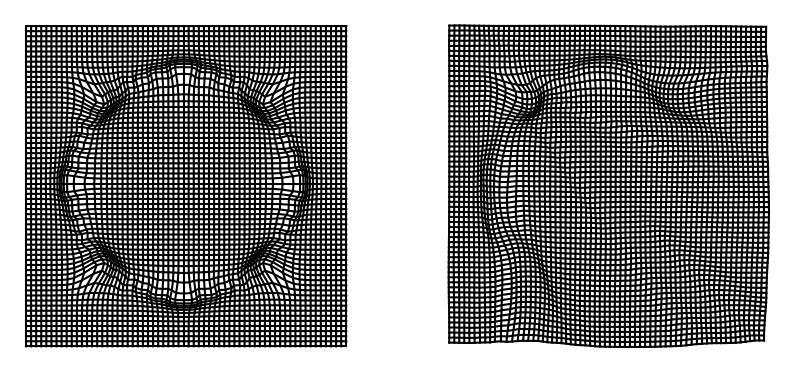

In [240]:
fig = plt.figure(figsize=(10, 10))
ax_in = fig.add_subplot(121)

ax_in = plot_warpgrid(x_out,interval=1)
ax_out = fig.add_subplot(122)
ax_out = plot_warpgrid(x_out_pred,interval=1)

## Compute pullback metric

In [231]:
def get_learned_diffeo(model):
    def diffeo(x):
        #x = x.to(device)
        x = x.float().to(device)
        y = model(x)
        return y
    
    return diffeo

In [232]:
diffeo = get_learned_diffeo(net)

pullback_metric = PullbackMetric(dim=2,embedding_dim=2,immersion=diffeo)

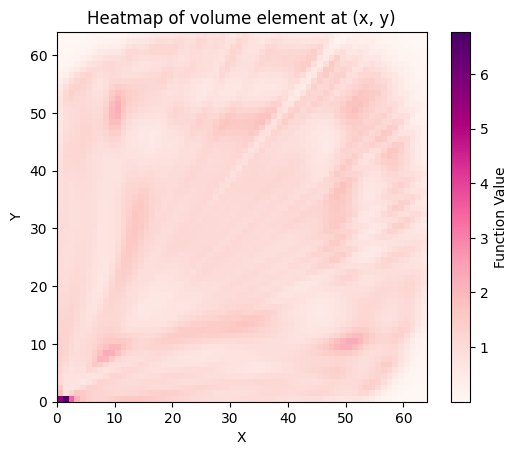

In [233]:
x = gs.linspace(0,64,64)
y = gs.linspace(0,64,64)
x_grid, y_grid = gs.meshgrid(x,y)

# Combine and reshape the x and y coordinates into a list of 2D points
points = gs.vstack((x_grid.ravel(), y_grid.ravel())).T

# Define your function
def volume_element(x, y):
    point = gs.array([x,y])
    g = pullback_metric.metric_matrix(point)
    vol = gs.sqrt(gs.abs(gs.linalg.det(g)))
    return vol

# Apply the function to each point in the list
values = gs.array([volume_element(x, y) for x, y in points])

# Reshape the values back into a 2D grid
z_values = values.reshape(x_grid.shape)

# Create the heatmap
plt.imshow(z_values, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='RdPu')
plt.colorbar(label='Function Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of volume element at (x, y)')
plt.show()